# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black;"><strong>Module importations</strong></span>

In [144]:
from MyModule import *

In [145]:
def selection_change():
    global raw_data_path
    raw_data_path = selected_option.get()
    print(raw_data_path)

root = tk.Tk()
root.title("Select one animal for rotation in pitch dark analysis")

selected_option = tk.StringVar()

animal_list = pd.read_excel(r'C:\Users\ayazici\Documents\census.xlsx', sheet_name='Study')['raw_data_path']

for i, animal in enumerate(animal_list):
    radio_button = tk.Radiobutton(root, text=animal, variable=selected_option, value=animal, command=selection_change)
    radio_button.pack(anchor='w')

root.mainloop()

P:\SharedFiles\Abdussamed\Pulvinar_rec_dark_80degs\rotation_light_dark_stitched_eye\animal21_a45d1s2_ephys\21a45d1s2_210526_120819


In [146]:
Saving_boolean = True

In [147]:
## qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
#%matplotlib widget 
#plt.ioff()
## plt.rcdefaults()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>FUNCTIONS</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plots(row_number, col_number, width, height, *args, suptitle=None,**kwargs)</strong></span>

In [148]:
def plots(*plot_commands, ncols=None, suptitle=None, supxlabel=None, supylabel=None, size=(9, 5), show=True, save=False, filename=None):
    num_plots = len(plot_commands)
    if ncols is None:
        ncols = int(num_plots ** 0.5) + 1  # Calcul automatique du nombre de colonnes

    nrows = (num_plots + ncols - 1) // ncols

    fig = plt.figure(figsize=size)
    # Création des sous-figures
    for i, command in enumerate(plot_commands, start=1):
        plt.subplot(nrows, ncols, i)
        exec(command)

    
    if supxlabel:
        fig.supxlabel(supxlabel)
    if supylabel:
        fig.supylabel(supylabel)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
    
    if show:
        plt.show()
    else:
        plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotVelocity(velocity)</strong></span>

In [149]:
def plotVelocity(velocityObject, direction, duration, rotationSpeed, xlim=None, color='c', xlabel=True, ylabel=True, save=False, filename='velocity.png', show=True, Plots=False):
    velocity = velocityObject[direction]
    durationFoo = duration
    xmin, xmax = durationFoo[0], durationFoo[-1]
    
    if not Plots:
        plt.figure()

    plt.plot(durationFoo, velocity, color=color, linewidth='1')
    plt.ylim(-rotationSpeed, rotationSpeed)
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(xmin, xmax)
    if ylabel:
        plt.ylabel(r'Mean Velocity $(^\circ/s)$')
    if xlabel:
        plt.xlabel(r'Time $(s)$')
    plt.yticks([-rotationSpeed, 0, rotationSpeed])

    if save:
        plt.savefig(filename, bbox_inches='tight')

    if not Plots:
        if show:
            plt.show()
        else:
            plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotPSTH(StudiedSpikeTimes)</strong></span>

In [150]:
def getPSTHparameters(StudiedSpikeTimes, timeObject, binResolution):
    local_trial_number = len(StudiedSpikeTimes)

    spike_number_per_trial = [[] for _ in range(local_trial_number)]
    edges = []

    for trial in range(local_trial_number):
        spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(timeObject[0], round(timeObject[-1])+binResolution, binResolution))


    frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
    mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

    Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
    Zscore[-1]=Zscore[-2]
    Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
    SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))

    return edges, Zscore, SEM

In [151]:
def plotPSTH(SpikeTimesObject, condition, unit,color='k',shadedcolor='c',binResolution = 0.03,xlabel=True,ylabel=True, title='', plotvelocity=False, velocitycolor='c', velocityalpha=0.13, xlim=None, save=False, filename='PSTH.png', show=True, smooth=True, Plots=False):
    if type(unit)==list:
        if type(condition)==list:
            StudiedSpikeTimes =  np.concatenate([np.concatenate([SpikeTimesObject[y][i] for i in unit]) for y in condition])
        else:
            StudiedSpikeTimes = np.concatenate([SpikeTimesObject[condition][i] for i in unit])
    else:
        if type(condition)==list:
            StudiedSpikeTimes = np.concatenate([SpikeTimesObject[y][unit] for y in condition])
        else:
            StudiedSpikeTimes = SpikeTimesObject[condition][unit]

    edges, Zscore, SEM = getPSTHparameters(StudiedSpikeTimes, duration, binResolution)

    if smooth:
        Zscore = savgol_filter(Zscore, 9, 3)

    if not Plots:
        plt.figure()

    plt.plot(edges[:-1], Zscore, color=color)
    plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)



    if plotvelocity:
        normalization = 1/rotationSpeed*max(abs(Zscore))
        rotation = MeanRotation[condition]
        
        if min(rotation) < -rotationSpeed/2:
            rotation = rotation * normalization
            haxis = np.zeros(len(duration))
        else:
            rotation = rotation * normalization
            haxis = np.zeros(len(duration))
        plt.plot(duration, rotation, color=velocitycolor, alpha=velocityalpha)
        plt.fill_between(duration, rotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)



    if xlim:
        plt.xlim(xlim)
    else:
        plt.margins(x=0)
    if ylabel:
        plt.ylabel('Z-Score FR')
    if xlabel:
        plt.xlabel('Time (s)')

    plt.title(title)

    if save:
        plt.savefig(filename, bbox_inches='tight')
    
    if not Plots:
        if show:
            plt.show()
        else:
            plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotRaster(spikeTimesObject)</strong></span>

In [152]:
def plotRaster(SpikeTimesObject, condition, unit, color='black', xlabel='Time (s)', ylabel='# Trial', extra=None, title='', xlim=None, plotvelocity=False, velocitycolor='k', velocityalpha=0.13, save=False, filename='Raster.png', show=True, psth=False, binResolution=0.03, shadedcolor='red', psthcolor='red', smooth=True, Plots=False):
    if type(unit)==list:
        if type(condition)==list:
            StudiedSpikeTimes =  np.concatenate([np.concatenate([SpikeTimesObject[y][i] for i in unit]) for y in condition])
        else:
            StudiedSpikeTimes = np.concatenate([SpikeTimesObject[condition][i] for i in unit])
    else:
        if type(condition)==list:
            StudiedSpikeTimes = np.concatenate([SpikeTimesObject[directiony][unit] for directiony in condition])
        else:
            StudiedSpikeTimes = SpikeTimesObject[condition][unit]
   
    

    linelengths = 1

    if not Plots:
        plt.figure()

    plt.eventplot(StudiedSpikeTimes, linelengths=linelengths, colors=color)

    if extra is not None:
        extra()
    
    ### annulate the offset due to python indexation
    def custom_formatter(x, pos):
        return f"{int(x) + 1}"
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

    if plotvelocity:
        normalization = len(StudiedSpikeTimes)/rotationSpeed
        rotation = MeanRotation[condition]
        
        if condition == 'CCW':
            rotation = rotation * normalization - min(rotation * normalization) - linelengths/2
            haxis = len(StudiedSpikeTimes)*np.ones(len(duration))
        elif condition == 'CW':
            rotation = rotation * normalization - linelengths/2
            haxis = np.zeros(len(duration)) - linelengths/2
        else:
            rotation = rotation
            haxis = np.zeros(len(duration))
        plt.plot(duration, rotation, color=velocitycolor, alpha=velocityalpha)
        plt.fill_between(duration, rotation, haxis, color=velocitycolor, alpha=velocityalpha*0.8)
    

    if xlim:
        plt.xlim(xlim)
    else:
        plt.margins(x=0)
    plt.ylim(0-linelengths/2,len(StudiedSpikeTimes)-1+linelengths/2)

    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.title(title)

    if psth:
        edges, Zscore, SEM = getPSTHparameters(StudiedSpikeTimes, duration, binResolution)
        if smooth:
            Zscore = savgol_filter(Zscore, 9, 3)
        plt.twinx()
        plt.plot(edges[:-1], Zscore, color=psthcolor)
        plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        if ylabel:
            plt.ylabel('Z-Score FR')
        if xlabel:
            plt.xlabel('Time (s)')

    if save:
        plt.savefig(filename, bbox_inches='tight')
        
    if not Plots:
        if show:
            plt.show()
        else:
            plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>figure1(unit)</strong></span>

In [153]:
def figure1(unit,duration, rotationSpeed, timeBef, timeAft, firstcolor='red',secondcolor='blue', save=False, filename='figure 1.png'):
      plots(
            f"plotVelocity(MeanRotation, 'CW',duration, rotationSpeed,color='{firstcolor}', xlabel=False, Plots=True)",
            f"plotVelocity(MeanRotation, 'CCW',duration, rotationSpeed,color='{secondcolor}',ylabel=False,xlabel=False, Plots=True)",
            f"plotRaster(SpikeTimes, 'CW', {unit}, color='{firstcolor}', xlabel=False, Plots=True)",
            f"plotRaster(SpikeTimes, 'CCW', {unit}, color='{secondcolor}',xlabel=False,ylabel=False, Plots=True)",
            f"plotPSTH(SpikeTimes, 'CW', {unit}, color='{firstcolor}', shadedcolor='{firstcolor}', Plots=True)",
            f"plotPSTH(SpikeTimes, 'CCW', {unit},color='{secondcolor}', shadedcolor='{secondcolor}',ylabel=False, Plots=True)",
            suptitle=f"Figure 1: Unit {unit}",
            save=save,
            filename=filename,
            ncols=2
      )

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>seeModulation(condition, modulated)</strong></span>

In [154]:
def seeModulation(condition,modulated, color='k', velocitycolor='k', velocityalpha=0.13, save=False, filename='Modulation', show = True):
      
      position = np.where([(modulation['selectivity'][neuron]==modulated.split()[0]) and (modulation['type'][neuron]==modulated.split()[1]) for neuron in range(Nclust)])[0]
      print(f'The {modulated} modulated neurons are {position}')

      by = modulated.split()[0]
      how = modulated.split()[1]

      for unit in np.where([modulation['selectivity'][neuron]==by and modulation['type'][neuron]==how for neuron in range(Nclust)])[0]:
            plots(
                  f"plotRaster(SpikeTimes, condition, 'CW', {unit}, color='{color}', xlabel=False, ylabel=False, plotvelocity=True, velocitycolor='{velocitycolor}', velocityalpha={velocityalpha}, Plots=True)",
                  f"plotRaster(SpikeTimes, condition, 'CCW', {unit}, color='{color}', xlabel=False, ylabel=False, plotvelocity=True, velocitycolor='{velocitycolor}', velocityalpha={velocityalpha}, Plots=True)",
                  suptitle=f'Unit {unit} {modulated} modulated',
                  supxlabel='Time (s)',
                  supylabel='# Trial',
                  save=save,
                  filename=filename,
                  show=show,
                  ncols=2
            )

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>split_path(path)</strong></span>

In [155]:
def split_path(path):
    drive, path_without_drive = os.path.splitdrive(path)
    path_segments = []
    while True:
        head, tail = os.path.split(path_without_drive)
        if tail:
            path_segments.insert(0, tail)
            path_without_drive = head
        else:
            if head:
                path_segments.insert(0, head)
            break
    path_segments.insert(0, drive)
    return path_segments

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Find Peaks</strong></span>

In [156]:
def find_peaks(studiedRef, f):
    centered_peaks, _ = scipy.signal.find_peaks(studiedRef, plateau_size=(0.3*f,5*f))

    AllPeaks, _ = scipy.signal.find_peaks(np.diff(studiedRef))

    peaks = []
    for center_pic in centered_peaks:
        peaks.append(AllPeaks[(AllPeaks > center_pic - 3 * f) & (AllPeaks < center_pic)][0])

    return peaks

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Initiation</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paths</strong></span>

In [157]:
parent_folder = os.path.dirname(raw_data_path)

exp_id = raw_data_path[raw_data_path.find('animal'):raw_data_path.find('animal')+len('animal')+10]

saving_folder = fr'C:\Users\ayazici\Documents\Analyses\{exp_id}\rotation'

print(exp_id.upper(), '-- Rotation in light and dark, with stitched eye analysis')

ANIMAL21_A45D1S2 -- Rotation in light and dark, with stitched eye analysis


## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of Parameters</strong></span>

In [158]:
timeBef   = 2
timeAft   = 8

refValue          = 'din04'
chanSpace         = 20                 #um
rotationSpeed     = 80                 #deg/s
ProbeType         = '32_optoElectrode'

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Data Importation</strong></span>

### For MUA

In [159]:
times_polytrodeAll = scipy.io.loadmat(os.path.join(raw_data_path, 'times_polytrodeAll.mat'))
m_class = times_polytrodeAll['mua_class']
'''
m_class[:,0] : indice of the cluster for each index
m_class[:,1] : time of the spike in ms
m_class[:,1]/1000 : time of the spike in s
'''

muaWf = times_polytrodeAll['clusWFmua']

### For SUA

In [160]:
c_class = times_polytrodeAll['cluster_class']  # units and associated time spiking

temp_idx = c_class[:,0]    # units

# find the units and remove the MUA
units = temp_idx!=0
temp_clus = c_class[units,0]

Nclust = len(np.unique(temp_clus))

# if not studied_unit:
#     studied_unit = list(range(1,Nclust+1))

temp_time = c_class[units,1]/1000  # temps de spike en seconde

temp_time_clust = []

for unit in range(Nclust):
    temps_spikes_sec = c_class[np.where(c_class[:,0]==unit)][:,1] / 1000
    temp_time_clust.append(temps_spikes_sec)

### General

In [161]:
clusterParam = h5py.File(os.path.join(raw_data_path,'rez.mat'),'r')['rez']
infos = clusterParam['ops']
f = int(infos['fs'][0][0])

os.chdir(parent_folder)

table_velocity = np.squeeze(h5py.File(os.path.join(parent_folder, f"{exp_id}_ADC00.mat"), 'r')['data'])

try:
    stereotaxic = h5py.File(os.path.join(parent_folder, f"VelocityData_{exp_id}.mat"), 'r')
except:
    stereotaxic = scipy.io.loadmat(os.path.join(parent_folder, f"VelocityData_{exp_id}.mat"))
ML_pos = np.squeeze(stereotaxic['All_ML'])[0]
AP_pos = np.squeeze(stereotaxic['All_AP'])[0]

In [162]:
#Load all the digital Input on the workspace

#DIN01 => photodiiode 1 is trig CAM
#DIN02 => LED
#DIN03 => trig ttl frame camera
#DIN04 => photodiiode 2 is the VS and start turntable

din = {
    '01':[],
    '02':[],
    '03':[],
    '04':[]
}

for dinkey in din.keys():
    filename = exp_id + '_DIN'+ str(dinkey) + '.mat'
    #with h5py.File(filename, 'r') as file:
    #    din[str(dinkey)] = file['data'][:]
    din[str(dinkey)] = np.squeeze(h5py.File(filename, 'r')['data'])


if refValue == 'din01':
    ref = din['01']
elif refValue == 'din02':
    ref = din['02']
elif refValue == 'din03':
    ref = din['03']
elif refValue == 'din04':
    ref = din['04']
else:
    print('Take a look to the indicated ref din')


time = np.arange(len(din['01'])) / f

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Trials beginning</strong></span>

In [163]:
def find_separation():
    largest_interval = 0
    foo, _ = scipy.signal.find_peaks(np.diff(ref))
    for i in range(1, len(foo)):
        interval = foo[i] - foo[i-1]
        if interval > largest_interval:
            largest_interval = interval
            mean_index = int(((foo[i] + foo[i-1]) / 2)/f)*f
    return mean_index

limit = find_separation()

In [164]:
time = time[limit:]
table_velocity = table_velocity[limit:]
ref = ref[limit:]

In [165]:
peaks = find_peaks(ref, f)

In [166]:
Ntrial = len(peaks)

print("Number of trials :", Ntrial)

Number of trials : 136


# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Rotation Objects</strong></span>

In [167]:
duration = []
RotationWise = []
MeanRotation = {'CW':[], 'CCW':[], 'NotResponding':[]}

def center_reduce(data):
    foo = savgol_filter(np.mean(data, axis=0), 50, 1)
    return foo/max(abs(foo))*rotationSpeed if max(abs(foo))>rotationSpeed/2 else foo/max(abs(foo))

def find_starting(data, direction):
    if direction == 'CW':
        seuil = np.mean(data[:2*f])+6*np.std(data[:baselineLenght*f])
        shiftIndex = np.where(data > seuil)[0][0]
    else:
        seuil = np.mean(data[:2*f])-6*np.std(data[:baselineLenght*f])
        shiftIndex = np.where(data < seuil)[0][0]
    return shiftIndex


rotationfooCW, rotationfooCCW, rotationfooNone = ([] for _ in range(3))

for peak in peaks:
    extra = 3
    baselineLenght = 3
    timeBefExtra = timeBef + extra ; timeAftExtra = timeAft + extra

    table_turn_trial = table_velocity[peak - timeBefExtra*f: peak + timeAftExtra*f]
    baseline = np.mean(table_turn_trial[:baselineLenght*f])
    table_turn_trial = table_turn_trial - baseline
    std = np.std(table_turn_trial[:baselineLenght*f]) ; baseline = np.mean(table_turn_trial[:baselineLenght*f])

    if np.mean(table_turn_trial[timeBefExtra*f:(timeBefExtra+4)*f])>baseline+4*std:
        RotationWise.append('CW') 
        rotationfooCW.append(table_turn_trial)
    elif np.mean(table_turn_trial[timeBefExtra*f:(timeBefExtra+4)*f])<-baseline-4*std:
        RotationWise.append('CCW')
        rotationfooCCW.append(table_turn_trial)
    else:
        RotationWise.append('NotResponding')
        rotationfooNone.append(table_turn_trial)

MeanRotation['CW'], MeanRotation['CCW'], MeanRotation['NotResponding'] = center_reduce(rotationfooCW), center_reduce(rotationfooCCW), center_reduce(rotationfooNone)

startCW = find_starting(MeanRotation['CW'], 'CW')
startCCW = find_starting(MeanRotation['CCW'], 'CCW')
start = int(np.mean([startCW, startCCW]))
shiftIndex = start - timeBef*f - extra*f
duration = np.arange(-timeBef, timeAft, 1/f)
    

for direction in ['CW', 'CCW', 'NotResponding']:
    MeanRotation[direction] = MeanRotation[direction][extra*f+shiftIndex:-extra*f+shiftIndex]

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Shift between 0 and rotation</strong></span>

In [168]:
# print(f"{shiftIndex}, {time[shiftIndex]}")

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Plots Mean Rotations</strong></span>

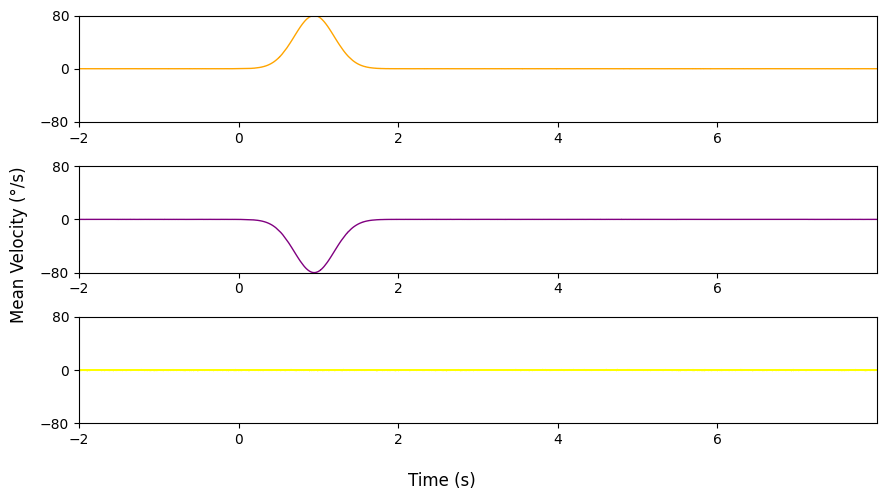

In [169]:
plots(
    "plotVelocity(MeanRotation, 'CW', duration, rotationSpeed, color='orange', xlabel=False, ylabel=False, Plots=True)",
    "plotVelocity(MeanRotation, 'CCW', duration, rotationSpeed, color='purple', xlabel=False, ylabel=False, Plots=True)",
    "plotVelocity(MeanRotation, 'NotResponding', duration, rotationSpeed, color='yellow', xlabel=False, ylabel=False, Plots=True)",
    supxlabel='Time (s)',
    supylabel='Mean Velocity (°/s)',
    ncols=1
)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>MUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Depths determination</strong></span>

In [170]:
# get the number of units
Nclust_mua = len(np.unique(m_class[:,0]))
ind_mua = m_class[:,0]


# find the peak wf to find the depth
szm = muaWf.shape
# DEPTH of the unit
# Get the mua activity that is in index 0 of the clusWF

allBasem = np.zeros((szm[1],szm[2]))
PkDepthUnit = np.zeros((szm[0], 1))
minMatrixm = np.zeros((szm[0], 1))

for spm in range(szm[0]):
    baselinem = np.mean(muaWf[spm][0:5],axis=0)-500 # offset -500 for potential positive baseline

    for bm in range(szm[2]):
        allBasem[:,bm] = baselinem[bm]*np.ones((szm[1]))

    spikeWavm = muaWf[spm,:,:]-500
    wfm = spikeWavm - allBasem

    minMatrixm[spm] = np.min(wfm)

    argMm = np.where(wfm==minMatrixm[spm])
    # get the depth of the unit
    uout = np.unique(argMm[1])
    argMm = []
    argMm = uout[0]
    PkDepthUnit[spm] = (argMm+1)*chanSpace # +1 because of Python indexation

In [171]:
x = 0 # depth of the tetrode

mapp = np.squeeze(infos['chanMap'])

if len(mapp)==32:
    Ntet = 16
elif len(mapp)==64:
    Ntet = 32
    chanSpace = chanSpace/2
else:
    print('WEIRD NUMBER OF TETRODES')

ArgallLayers = {i: [] for i in range(Ntet)}

factorTet = chanSpace * len(mapp)/Ntet

for lay in range(Ntet):
    # H5 electrode
    if np.sum(mapp[0:4]==[33, 38, 44, 40])==4:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    else:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    x += factorTet

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Associating tetrodes with depth</strong></span>

In [172]:
m_class_tet = np.zeros((len(m_class),2))


# First column
for tet in ArgallLayers:
    for unit in ArgallLayers[tet]:
        pos = np.where(m_class[:,0]-1 == unit)[0]
        m_class_tet[pos,0] = tet
        
# Second column 
m_class_tet[:,1] = m_class[:,1]

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times of tetrodes</strong></span>

In [173]:
AllSpikeTimesMUA = np.empty((Ntet,Ntrial),dtype=object)


for tet in range(Ntet):
    spikingTimeTet = m_class_tet[np.where(m_class_tet[:,0] == tet)[0],1]/1000

    for trial in range(Ntrial):
        upperTime = (peaks[trial]+shiftIndex)/f + timeAft + limit/f
        lowerTime = (peaks[trial]+shiftIndex)/f - timeBef + limit/f
        rectifierTime = - lowerTime - timeBef
        
        boolean = (spikingTimeTet > lowerTime) & (spikingTimeTet < upperTime)
        AllSpikeTimesMUA[tet][trial] = spikingTimeTet[boolean] + rectifierTime

In [174]:
SpikeTimesMUA = {
    'CW': [[] for _ in range(Ntet)],
    'CCW': [[] for _ in range(Ntet)],
    'NotResponding': [[] for _ in range(Ntet)]
}


for tet in range(len(AllSpikeTimesMUA)):
    for trial in range(Ntrial):
        if RotationWise[trial] == 'CW':
            direction = 'CW'
        elif RotationWise[trial] == 'CCW':
            direction = 'CCW'
        else:
            direction = 'NotResponding'
        
        SpikeTimesMUA[direction][tet].append([AllSpikeTimesMUA[tet][trial]])

        
for condition in SpikeTimesMUA:
    for tet in range(len(SpikeTimesMUA[condition])):
        SpikeTimesMUA[condition][tet] = np.array([SpikeTimesMUA[condition][tet][trial][0] for trial in range(len(SpikeTimesMUA[condition][tet]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Automatic detection of 0</strong></span>

In [175]:
if any([data.size==0 for data in SpikeTimesMUA['CW']]):
    for tet in range(Ntet):
        if (SpikeTimesMUA['CW'][tet].size == 0) and (SpikeTimesMUA['CW'][tet+1].size != 0):
            LP_ref = tet+1
            break
else:
    LP_ref = 0

if any([data.size==0 for data in SpikeTimesMUA['CW']]):
    for tet in range(Ntet):
        if (SpikeTimesMUA['CCW'][tet].size == 0) and (SpikeTimesMUA['CCW'][tet+1].size != 0):
            if LP_ref != tet+1:
                raise Exception("Do detection manually bro.")
            break

print(f"Automatic detection of the LP is the tetrode #{LP_ref} (Python indexation)")

Automatic detection of the LP is the tetrode #0 (Python indexation)


In [176]:
DepthTetrode = np.zeros(Ntet)
AllDepth = np.zeros(Nclust)

for tet in range(Ntet):
    DepthTetrode[tet] = (tet-LP_ref)*factorTet

for unit in range(Nclust):
    AllDepth[unit] = PkDepthUnit[unit][0] - LP_ref*factorTet

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Figures</strong></span>

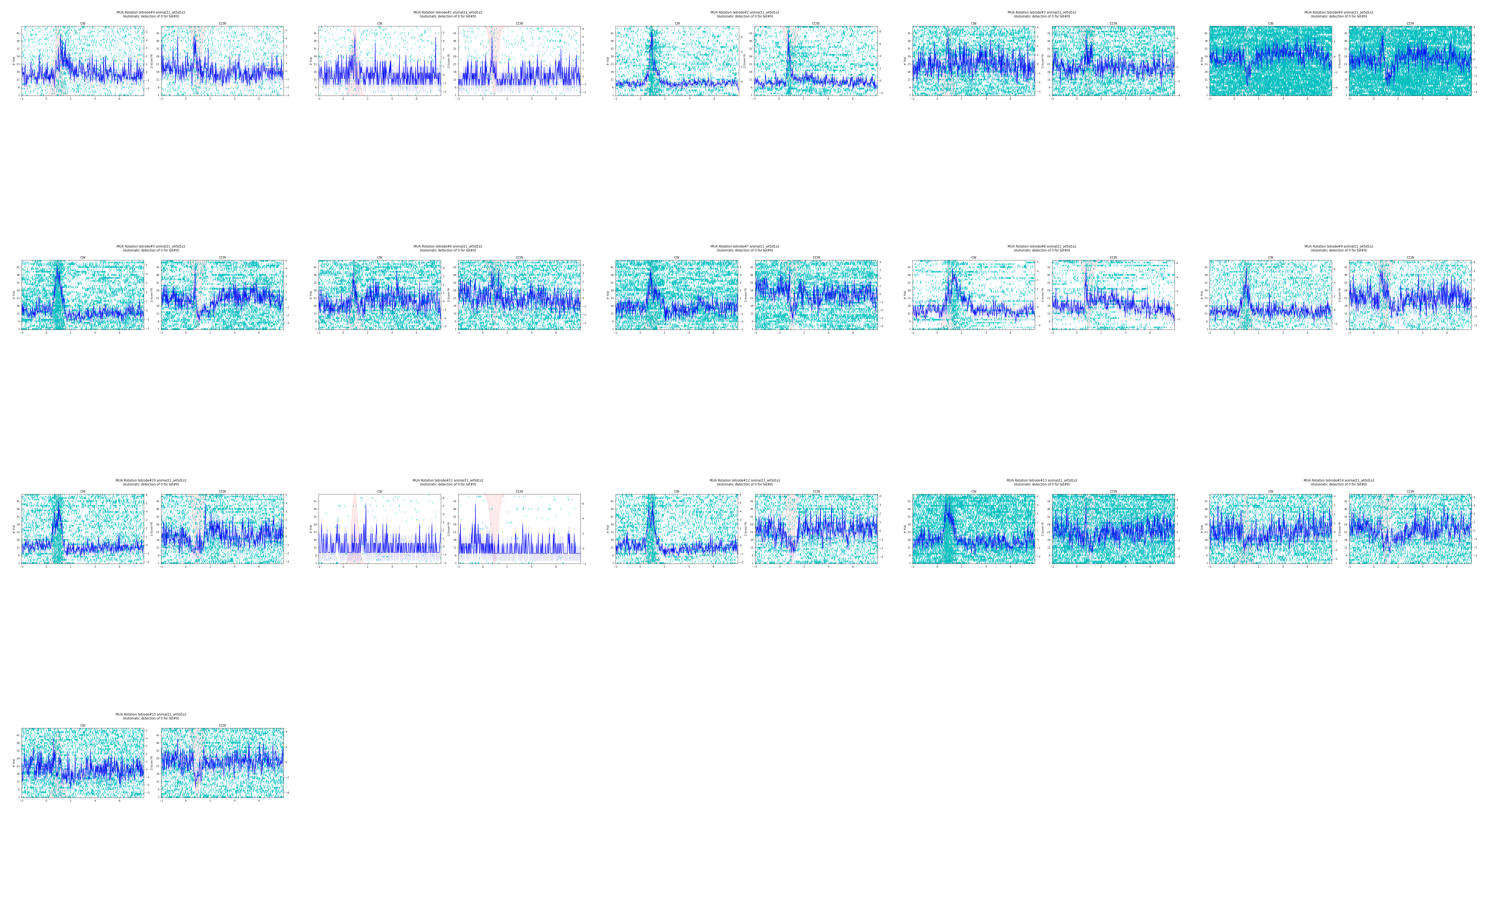

In [177]:
MUA_saving_folder = os.path.join(saving_folder, 'MUA')
os.makedirs(MUA_saving_folder, exist_ok=True)

apercu = []

for tet in tqdm(range(Ntet), total=Ntet, desc=f"Raster plots for MUA", leave=False):
        plots(
                "plotRaster(SpikeTimesMUA, 'CW', tet, color='c', xlabel=False, plotvelocity=True, velocitycolor='red', velocityalpha=0.1, Plots=True, psth=True, psthcolor='blue', shadedcolor='blue', smooth=False, title='CW')",
                "plotRaster(SpikeTimesMUA, 'CCW', tet, color='c', xlabel=False, plotvelocity=True, velocitycolor='red', velocityalpha=0.1, Plots=True, ylabel=False, psth=True, psthcolor='blue', shadedcolor='blue', smooth=False, title='CCW')",
                suptitle=f"MUA Rotation tetrode#{tet} {exp_id}\n(Automatic detection of 0 for tet#{LP_ref})",
                save = Saving_boolean,
                filename = os.path.join(MUA_saving_folder,f"MUA_rotation_{exp_id}_tet#{tet}.png"),
                ncols=2,
                size=(15,5),
                show=False
        )
        apercu.append(os.path.join(MUA_saving_folder,f"MUA_rotation_{exp_id}_tet#{tet}.png"))

plt.figure(figsize=(15, 10))

ncolonne = 5
nligne = len(apercu)//ncolonne + 1

for i in range(ncolonne*nligne):
        if i < len(apercu):
                img = plt.imread(apercu[i])
                plt.subplot(nligne, ncolonne, i+1)
                plt.imshow(img)
                plt.axis('off')
        else:
                plt.subplot(nligne, ncolonne, i+1)
                plt.axis('off')

plt.tight_layout()
plt.show()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>SUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>All Spiking Times</strong></span>

In [178]:
## Spike times organized by cluster
AllSpikeTimes = np.empty((Nclust, Ntrial), dtype=object)


for unit in range(Nclust):
    spikingTimeClus = temp_time_clust[unit]

    for trial in range(Ntrial):
        upperTime = (peaks[trial]+shiftIndex)/f + timeAft + limit/f
        lowerTime = (peaks[trial]+shiftIndex)/f - timeBef + limit/f
        rectifierTime = - lowerTime - timeBef

        bornes = np.logical_and(lowerTime < spikingTimeClus, spikingTimeClus < upperTime)

        AllSpikeTimes[unit][trial] = spikingTimeClus[bornes] + rectifierTime

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times according to condition</strong></span>

In [179]:
SpikeTimes = {
    'CW': [[] for _ in range(Nclust)],
    'CCW': [[] for _ in range(Nclust)],
    'NotResponding': [[] for _ in range(Nclust)]
}


for neuron in range(len(AllSpikeTimes)):
    for trial in range(Ntrial):
        if RotationWise[trial] == 'CW':
            condition = 'CW'
        elif RotationWise[trial] == 'CCW':
            condition = 'CCW'
        else:
            condition = 'NotResponding'
        
        SpikeTimes[condition][neuron].append([AllSpikeTimes[neuron][trial]])


for condition in SpikeTimes:
    for unit in range(len(SpikeTimes[condition])):
        SpikeTimes[condition][unit] = np.array([SpikeTimes[condition][unit][trial][0] for trial in range(len(SpikeTimes[condition][unit]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Raster plots</strong></span>

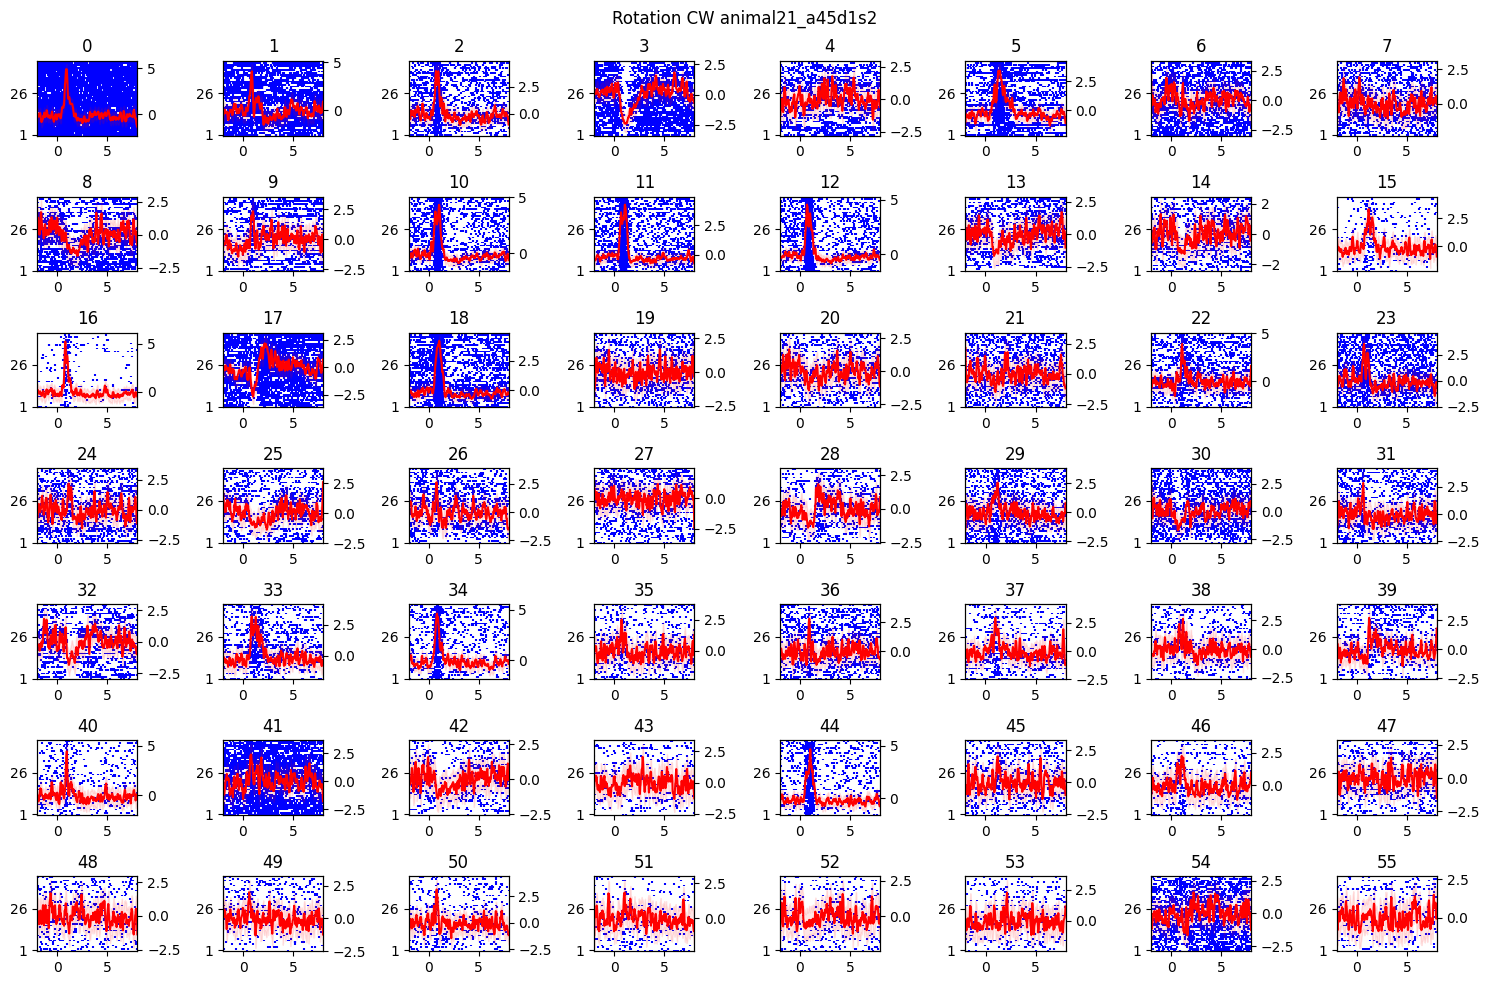

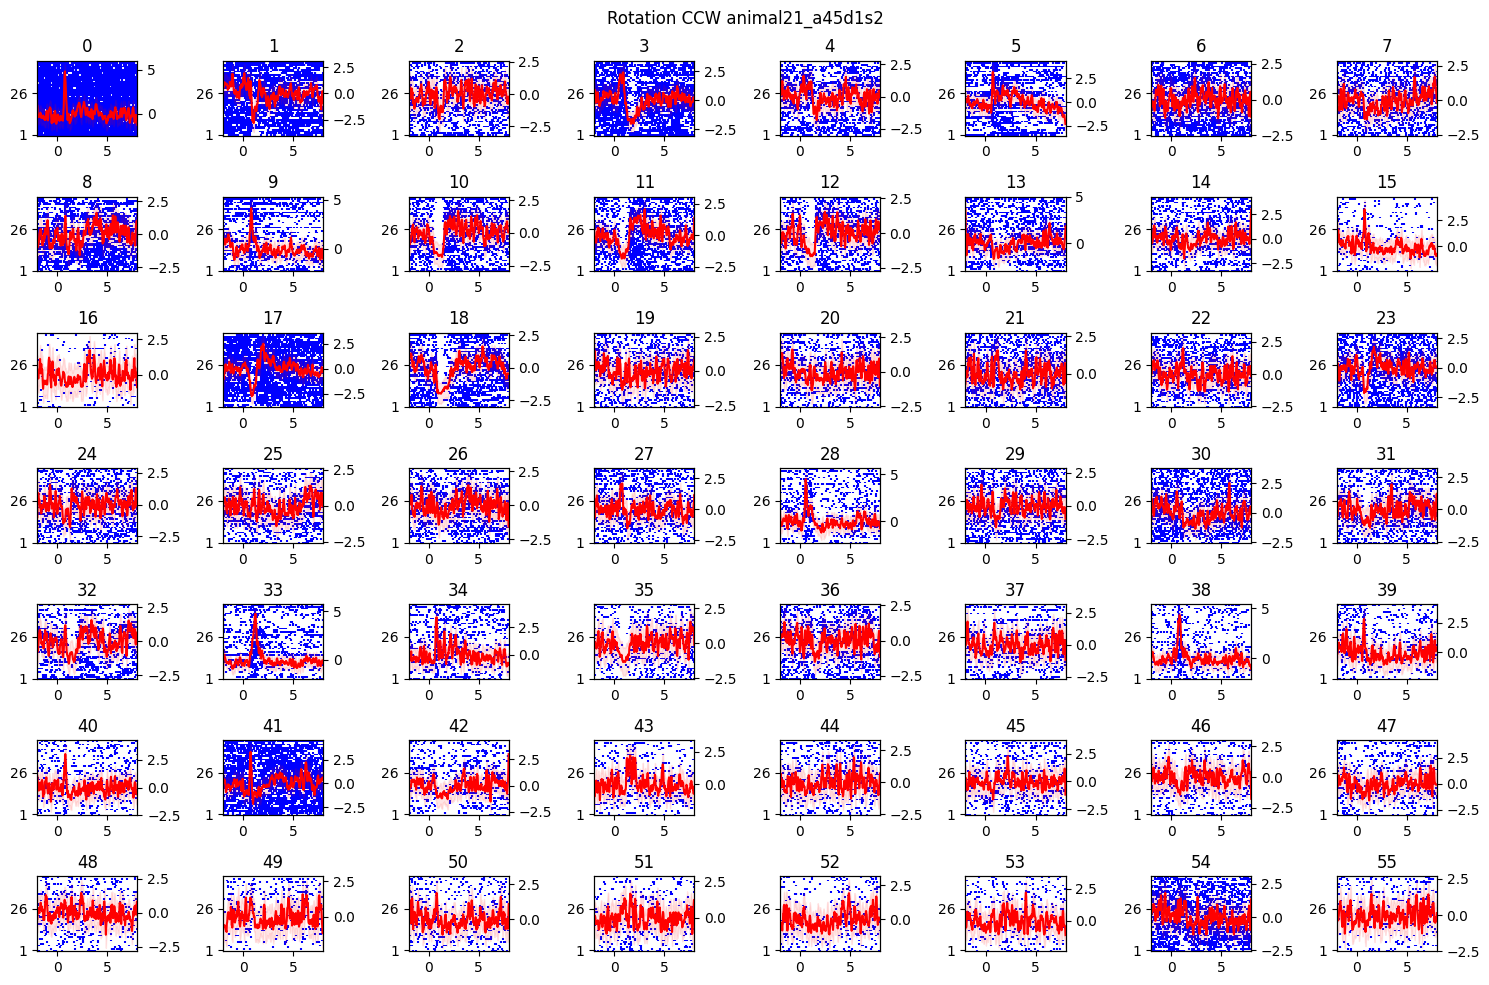

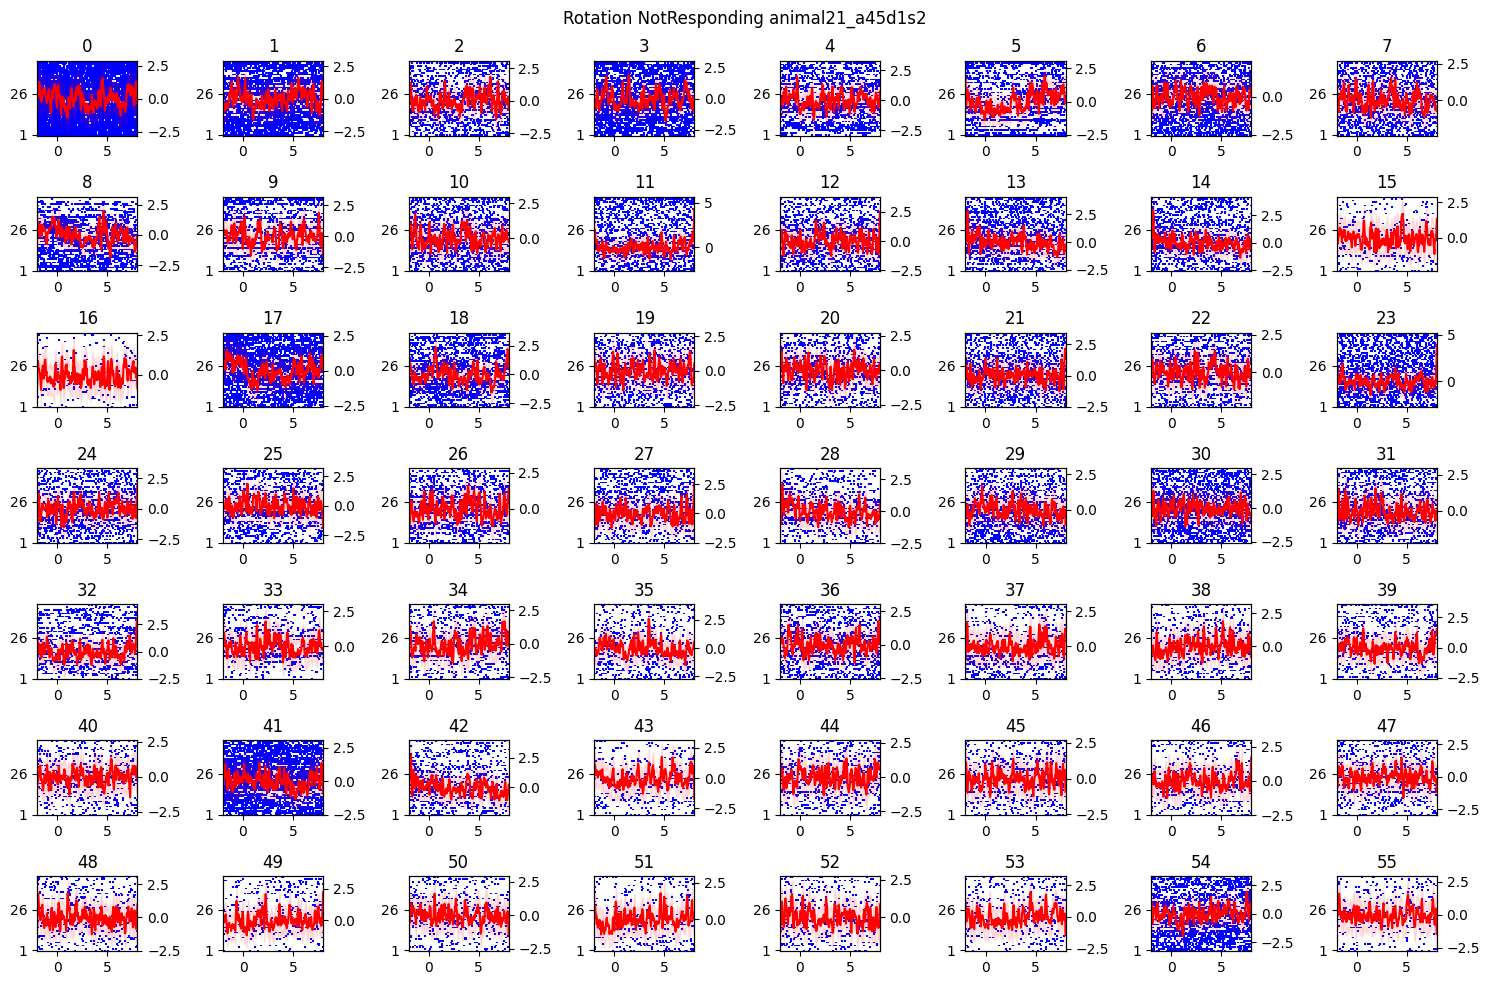

In [180]:
Raster_saving_folder = os.path.join(saving_folder, 'Raster')
os.makedirs(Raster_saving_folder, exist_ok=True)


for condition in ['CW', 'CCW', 'NotResponding']:
    number = len(SpikeTimes[condition])
    element = f"Rotation {condition}"
    plots(
        *[f"plotRaster(SpikeTimes, '{condition}', {unit}, Plots=True, xlabel=False, ylabel=False, title='{unit}', color='blue', psth=True, psthcolor='red', shadedcolor='red')" for unit in range(number)],
        suptitle=f"{element} {exp_id}",
        save=Saving_boolean,
        filename=os.path.join(Raster_saving_folder, f"Raster_{exp_id}_{condition}.png"),
        size=(15,10),
        show=True
    )

In [181]:
All_raster_saving_folder = os.path.join(saving_folder, 'Raster', 'All')
for direction in ['CW', 'CCW', 'NotResponding']:
    os.makedirs(os.path.join(All_raster_saving_folder, direction), exist_ok=True)

for condition in ['CW', 'CCW', 'NotResponding']:
    element = f"Rotation {condition}"
    for unit in tqdm(range(len(SpikeTimes[condition])), total=len(SpikeTimes[condition]), desc=f"Raster plots for {condition} rotation", leave=False):
        plotRaster(SpikeTimes, condition, unit,
                   title=f"Unit {unit} - {condition} rotation - {exp_id}",
                   color='blue',
                   psth=True, psthcolor='red', shadedcolor='red',
                   save=Saving_boolean,
                   filename=os.path.join(All_raster_saving_folder, condition, f"Raster_{exp_id}_{condition}_unit{unit}.png"),
                   show=False)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>PSTH Heatmap</strong></span>

In [182]:
# Zmaxiscore = [[] for _ in range(len(SpikeTimes['first']['CW']))]

# for unit in range(len(SpikeTimes['first']['CW'])):
#     StudiedSpikeTimes = SpikeTimes['first']['CW'][unit]

#     color='k'
#     shadedcolor='k'
#     ylabel=True
#     xlabel=True

#     local_trial_number = len(StudiedSpikeTimes)

#     binResolution=0.03

#     spike_number_per_trial = [[] for _ in range(local_trial_number)]
#     edges = []
#     unitary_firing_rate = [[] for _ in range(local_trial_number)]

#     for trial in range(local_trial_number):
#         spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

#     frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
#     mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

#     Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency)
#     Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency)
#     SEM = np.std(Zunitary)/np.sqrt(len(Zunitary))

#     # # plt.figure(figsize=(15,6))
#     # plt.plot(edges[:-1], Zscore, color=color)
#     # plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
#     # plt.xlim(-timeBef,timeAft)
#     # if ylabel:
#     #     plt.ylabel('PSTH')
#     # if xlabel:
#     #     plt.xlabel('Time (s)')
#     # plt.show()

#     Zmaxiscore[unit] = Zscore



# # del Zmaxiscore[22]


# # # Créer des données aléatoires pour le heatmap (une matrice 10x10)
# # data = np.random.rand(10, 100)

# # Afficher le heatmap
# plt.figure(figsize=(15, 5))
# plt.imshow(Zmaxiscore, cmap='coolwarm', interpolation='nearest', vmin=-2,vmax=2)
# plt.colorbar()  # Ajouter une barre de couleur pour référence
# # plt.xticks(duration)
# plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Statistics</strong></span>

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spike counting</strong></span>

In [183]:
numberBef, numberDur, diffBefDur, sumBefDur = ({
    'CW': [[] for _ in range(Nclust)],
    'CCW': [[] for _ in range(Nclust)]
} for _ in range(4))

vMI = {
    'CW': [[] for _ in range(Nclust)],
    'CCW': [[] for _ in range(Nclust)]
}

dirMI = [[] for _ in range(Nclust)]

good_baseline = [[] for _ in range(Nclust)]


foo = np.where(MeanRotation['CW'] > rotationSpeed/2)[0]
windowDur = [foo[0], foo[-1]]
windowBef = [1*f, 1*f+len(foo)]

for condition in ['CW', 'CCW']:
    for unit in range(Nclust):
        for trial in range(len(SpikeTimes[condition][unit])):
            fooSpike = SpikeTimes[condition][unit][trial]
            numberBef[condition][unit].append(np.sum((fooSpike < duration[windowBef[1]]) & (fooSpike > duration[windowBef[0]])))
            numberDur[condition][unit].append(np.sum((fooSpike < duration[windowDur[1]]) & (fooSpike > duration[windowDur[0]])))
            diffBefDur[condition][unit].append(numberDur[condition][unit][-1] - np.mean(numberBef[condition][unit][-1]))
            sumBefDur[condition][unit].append(numberDur[condition][unit][-1] + np.mean(numberBef[condition][unit][-1]))
        vMI[condition][unit] = np.mean(diffBefDur[condition][unit]) / np.mean(sumBefDur[condition][unit])
        if np.mean(numberBef[condition][unit])/(len(foo)/f) >= 0.5:
            good_baseline[unit] = True
        else:
            good_baseline[unit] = False

meanCW = np.mean(numberDur['CW'], axis=1)
meanCCW = np.mean(numberDur['CCW'], axis=1)
dirMI = (meanCW - meanCCW) / (meanCW + meanCCW)

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paired Wilcoxon Test</strong></span>

In [184]:
statistics_vMI, p_values_vMI = ({
    'CW': [[] for _ in range(Nclust)],
    'CCW': [[] for _ in range(Nclust)]
} for _ in range(2))

statistics_dirMI, p_values_dirMI = ([[] for _ in range(Nclust)] for _ in range(2))


for condition in ['CW', 'CCW']:
        for unit in range(Nclust):
            try:
                results_vMI = wilcoxon(numberBef[condition][unit], numberDur[condition][unit])
                statistics_vMI[condition][unit].append(results_vMI[0])
                p_values_vMI[condition][unit].append(results_vMI[1])
            except ValueError:
                statistics_vMI[condition][unit].append(0)
                p_values_vMI[condition][unit].append(1)


for unit in range(Nclust):
    try:
        results_dirMI = wilcoxon(numberDur['CW'][unit], numberDur['CCW'][unit])
        statistics_dirMI[unit].append(results_dirMI[0])
        p_values_dirMI[unit].append(results_dirMI[1])
    except ValueError:
        statistics_dirMI[unit].append(0)
        p_values_dirMI[unit].append(1)

c:\Users\gbouvier\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of significant units by condition</strong></span>

In [185]:
p_value_threshold = 0.05

significance_vMI = {
        'CW': [],
        'CCW': []
    }

significance_dirMI = [[] for _ in range(Nclust)]



for condition in ['CW', 'CCW']:
    significance_vMI[condition] = np.where([p_values_vMI[condition][neuron][0]<p_value_threshold for neuron in range(Nclust)])[0]

significance_dirMI = np.where([p_values_dirMI[neuron][0]<p_value_threshold for neuron in range(Nclust)])[0]

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Visual Overview Of Spike Numbers Before & During</strong></span>

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Resuming Modulations & Preferences</strong></span>

In [186]:
modulation = {
    'selectivity': [[] for _ in range(Nclust)],
    'type': [[] for _ in range(Nclust)],
}



for unit in range(Nclust):
    both = (unit in significance_vMI['CW']) and (unit in significance_vMI['CCW'])
    CW = unit in significance_vMI['CW']
    CCW = unit in significance_vMI['CCW']



    if not (both or CW or CCW):
        modulation['selectivity'][unit] = 'unmodulated'
        modulation['type'][unit] = '0'
    else:
        fooCW = np.mean(diffBefDur['CW'][unit])
        fooCCW = np.mean(diffBefDur['CCW'][unit])

        if both:
            modulation['selectivity'][unit] = 'both'
            if (fooCW >= 0) and (fooCCW >= 0):
                modulation['type'][unit] = '++'
            elif (fooCW < 0) and (fooCCW < 0):
                modulation['type'][unit] = '--'
            elif (fooCW < 0) and (fooCCW >= 0):
                modulation['type'][unit] = '-+'
            elif (fooCW >= 0) and (fooCCW < 0):
                modulation['type'][unit] = '+-'
        elif CW:
            modulation['selectivity'][unit] = 'CW'
            modulation['type'][unit] = '+' if fooCW >= 0 else '-'
        elif CCW:
            modulation['selectivity'][unit] = 'CCW'
            modulation['type'][unit] = '+' if fooCCW >= 0 else '-'


# Convert lists -> NumPy
for condition in modulation:
    modulation[condition] = np.array(modulation[condition])

In [187]:
preference = [[] for _ in range(Nclust)]


for unit in range(Nclust):
    if unit in significance_dirMI:
        preference[unit] = 'CW' if dirMI[unit]>0 else 'CCW'
    else:
        preference[unit] = None

In [192]:
foo = ['CW+', 'CCW+', 'CW-', 'CCW-', 'both++', 'both--', 'both+-', 'both-+', 'unmodulated0']

Modulation_saving_folder = os.path.join(saving_folder, 'Modulation')
for modulated in foo:
    os.makedirs(os.path.join(Modulation_saving_folder, modulated), exist_ok=True)


for modulationWay in tqdm(foo, total=len(foo), desc=f'Rotation modulation figures loading', leave=False):
    selectivity_plus_type = [modulation['selectivity'][i] + modulation['type'][i] for i in range(Nclust)]
    position = np.where(modulationWay == np.array(selectivity_plus_type))[0]
    for i in position:
        plt.figure(figsize=(15,5))
        plt.subplot(3,2,1)
        plt.plot(duration, MeanRotation['CW'], color='blue')
        plt.ylim(-rotationSpeed, rotationSpeed)
        plt.margins(0)
        plt.axis('off')
        plt.subplot(3,2,2)
        plt.plot(duration, MeanRotation['CCW'], color='red')
        plt.ylim(-rotationSpeed, rotationSpeed)
        plt.margins(0)
        plt.axis('off')
        plt.subplot(3,2, (3, 5))
        plotRaster(SpikeTimes, 'CW', i, color='c', Plots=True, psth=True, psthcolor='b', shadedcolor='b')
        plt.subplot(3,2, (4, 6))
        plotRaster(SpikeTimes, 'CCW', i, color='#FF69B4', Plots=True, ylabel=False, psth=True, psthcolor='red', shadedcolor='red')
        #plt.subplot(221)
        #plotRaster(SpikeTimes, 'CW', i, color='blue', show=False, xlabel=False, title='CW')
        #plt.subplot(222)
        #plotRaster(SpikeTimes, 'CCW', i, color='red', show=False, xlabel=False, title='CCW')
        #plt.subplot(223)
        #plotPSTH(SpikeTimes, 'CW', i, color='blue', shadedcolor='blue', show=False, plotvelocity=True, velocitycolor='blue', velocityalpha=0.5)
        #plt.subplot(224)
        #plotPSTH(SpikeTimes, 'CCW', i, color='red', shadedcolor='red', show=False, plotvelocity=True, velocitycolor='red', velocityalpha=0.5)
        plt.suptitle(f"Unit {i} {modulationWay} modulated -- {exp_id}")
        if Saving_boolean:
            plt.savefig(os.path.join(Modulation_saving_folder, modulationWay, f"Modulation_{modulationWay}_{exp_id}_unit#{i}.png"))
        plt.close()

Rotation modulation figures loading:   0%|          | 0/9 [00:00<?, ?it/s]

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Showing Numerical Results</strong></span>

In [193]:
print(f"Units CW-modulated : {significance_vMI['CW']}\n")

print(f"Units CCW-modulated : {significance_vMI['CCW']}")

Units CW-modulated : [ 0  1  2  3  5  8  9 10 11 12 13 14 15 16 17 18 21 22 23 24 25 28 29 30
 32 33 34 35 37 38 40 41 42 44 46 50]

Units CCW-modulated : [ 0  1  5  7  9 10 11 12 13 17 18 19 20 22 23 24 26 28 31 33 34 35 38 40
 42 46 51 55]


# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Variables</strong></span>

In [194]:
if Saving_boolean:
    rotation_data = {
        'exp_id': exp_id,
        'timeBef': timeBef,
        'timeAft': timeAft,
        'refValue': refValue,
        'din': din,
        'time': time,
        'chanSpace': chanSpace,
        'rotationSpeed': rotationSpeed,
        'ProbeType': ProbeType,
        # 'f': f,
        'ML_pos': ML_pos,
        'AP_pos': AP_pos,
        'SpikeTimesMUA': SpikeTimesMUA,
        'Ntrial': Ntrial,
        'protocolSeparationIndex': limit,
        'SpikeTimes': SpikeTimes,
        'ref': ref,
        'peaks': peaks,
        'RotationWise': RotationWise,
        'MeanRotation': MeanRotation,
        'duration': duration,
        'table_velocity': table_velocity,
        'shiftIndex': shiftIndex,
        'c_class': c_class,
        'Nclust': Nclust,
        'm_class': m_class,
        'm_class_tet': m_class_tet,
        'Nclust_mua': Nclust_mua,
        'Ntet': Ntet,
        'allBasem': allBasem,
        'PkDepthUnit': PkDepthUnit,
        'mapp': mapp,
        'ArgallLayers': ArgallLayers,
        'DepthTetrode': DepthTetrode,
        'AllDepth': AllDepth,
        'windowBef': windowBef,
        'windowDur': windowDur,
        'numberBef': numberBef,
        'numberDur': numberDur,
        'diffBefDur': diffBefDur,
        'sumBefDur': sumBefDur,
        'statistics_vMI': statistics_vMI,
        'statistics_dirMI': statistics_dirMI,
        'p_values_vMI': p_values_vMI,
        'p_values_dirMI': p_values_dirMI,
        'significance_vMI': significance_vMI,
        'significance_dirMI': significance_dirMI,
        'modulation': modulation,
        'preference': preference,
        'vMI':vMI,
        'dirMI': dirMI,
        'good_baseline': good_baseline,
    }



    file = os.path.join(os.path.dirname(saving_folder), exp_id+"_rotation_data.pickle")
        
    # Sauvegarde des variables dans un fichier
    with open(file, 'wb') as FILE_WRITTER:
        pickle.dump(rotation_data, FILE_WRITTER)
        FILE_WRITTER.close()